<a href="https://colab.research.google.com/github/inbarhub/YDATA_DL_assignments_2021-2022/blob/main/H.W_9_Text_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN for text generation


In this exercise, you'll unleash the hidden creativity of your computer, by letting it generate Country songs (yeehaw!). You'll train a character-level RNN-based language model, and use it to generate new songs.


### Special Note

Our Deep Learning course was packed with both theory and practice. In a short time, you've got to learn the basics of deep learning theory and get hands-on experience training and using pretrained DL networks, while learning PyTorch.  
Past exercises required a lot of work, and hopefully gave you a sense of the challenges and difficulties one faces when using deep learning in the real world. While the investment you've made in the course so far is enormous, We strongly encourage you to take a stab at this exercise. 

Some songs contain no lyrics (for example, they just contain the text "instrumental"). Others include non-English characters. You'll often need to preprocess your data and make decisions as to what your network should actually get as input (think - how should you treat newline characters?)

More issues will probably pop up while you're working on this task. If you face technical difficulties or find a step in the process that takes too long, please let me know. It would also be great if you share with the class code you wrote that speeds up some of the work (for example, a data loader class, a parsed dataset etc.)

## RNN for Text Generation
In this section, we'll use an LSTM to generate new songs. You can pick any genre you like, or just use all genres. You can even try to generate songs in the style of a certain artist - remember that the Metrolyrics dataset contains the author of each song. 

For this, we’ll first train a character-based language model. We’ve mostly discussed in class the usage of RNNs to predict the next word given past words, but as we’ve mentioned in class, RNNs can also be used to learn sequences of characters.

First, please go through the [PyTorch tutorial](https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html) on generating family names. You can download a .py file or a jupyter notebook with the entire code of the tutorial. 

As a reminder of topics we've discussed in class, see Andrej Karpathy's popular blog post ["The Unreasonable Effectiveness of Recurrent Neural Networks"](http://karpathy.github.io/2015/05/21/rnn-effectiveness/). You are also encouraged to view [this](https://gist.github.com/karpathy/d4dee566867f8291f086) vanilla implementation of a character-level RNN, written in numpy with just 100 lines of code, including the forward and backward passes.  

Other tutorials that might prove useful:
1. http://warmspringwinds.github.io/pytorch/rnns/2018/01/27/learning-to-generate-lyrics-and-music-with-recurrent-neural-networks/
1. https://github.com/mcleonard/pytorch-charRNN
1. https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb

### Final Tips
As a final tip, we do encourage you to do most of the work first on your local machine. They say that Data Scientists spend 80% of their time cleaning the data and preparing it for training (and 20% complaining about cleaning the data and preparing it). Handling these parts on your local machine usually mean you will spend less time complaining. You can switch to the cloud once your code runs and your pipeline is in place, for the actual training using a GPU.  

We also encourage you to use a small subset of the dataset first, so things run smoothly. The Metrolyrics dataset contains over 300k songs. You can start with a much much smaller set (even 3,000 songs) and try to train a network based on it. Once everything runs properly, add more data. 

Good luck!  

---
#### This exericse was originally written by Dr. Omri Allouche.

In [ ]:
# Same imports from the previous songs task

from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
# Some imports for the notebook to work
import re
import time
import copy
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn imports
from sklearn.model_selection import train_test_split

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset
from torch.autograd import Variable

### Read the data and clean it

In [ ]:
raw_df = pd.read_parquet(
    "/content/drive/MyDrive/Y-Data/Semester II/Deep Learning/Assignments/Assignment 8 - Word Embedding + Text Classification/data/metrolyrics.parquet"
)

In [5]:
print(raw_df.iloc[0].lyrics)
print(raw_df.iloc[0].sent)

[HEALY]
[spoken] This is Bert Healy saying ...
[singing now] Hey, hobo man
Hey, Dapper Dan
You've both got your style
But Brother,
You're never fully dressed
Without a smile!
Your clothes may be Beau Brummelly
They stand out a mile --
But Brother,
You're never fully dressed
Without a smile!
Who cares what they're wearing
On Main Street,
Or Saville Row,
It's what you wear from ear to ear
And not from head to toe
(That matters)
So, Senator,
So, Janitor,
So long for a while
Remember,
You're never fully dressed
Without a smile!
[BOYLAN SISTER]
Ready or not, here he goes
Listen to Bert
Tap his smilin' toes
[HEALY]
[spoken] Ah, the lovely Boylan Sisters
[BOYLAN SISTERS]
Doo doodle-oo doo
Doo doodle-oo doo
Doo doo doo doo
Doo doo doo doo
Your clothes may be Beau Brummelly
They stand out a mile
But, bother
You're never fully dressed
You're never dressed
Without an
[CONNIE BOYLAN]
S-
[BONNIE BOYLAN]
M-
[RONNIE BOYLAN]
I-
[CONNIE BOYLAN]
L-
[ALL THREE]
E.
Smile darn ya smile.
[ALL]
That matters


In [6]:
string.printable

'0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ \t\n\r\x0b\x0c'

In [ ]:
all_characters = string.printable
number_of_characters = len(all_characters)


def preprocess_words(raw_str):
    # 1. Remove problematic seen regex matches
    cleaned_str = re.sub(
        "(\[[a-zA-Z ,-:!]+\]|\([a-zA-Z \*,-:!]+\)|\{[a-zA-Z \*,-:!]+\}|--[a-zA-Z \*,-:!]+--|chorus)",
        " ",
        raw_str,
    )

    # 2. Remove characters out of our all_characters dictionary
    final_str = "".join(filter(lambda x: x in string.printable, cleaned_str))
    return final_str


def preprocess_df(df):
    # Remove songs without lyrics
    df = df[~df.lyrics.str.contains("licensing restrictions")]

    # Remove songs with non-english characters
    df = df[df.lyrics.map(lambda x: x.isascii())]

    df["lyrics_preprocessed"] = df.lyrics.map(lambda x: preprocess_words(x))

    # Limit lyrics to min of 100 chars and max length of 3000 (avoid short instrumental songs / too long inputs)
    df = df[
        (df.lyrics_preprocessed.str.len() >= 100)
        & (df.lyrics_preprocessed.str.len() <= 3000)
    ]

    return df


pp_df = preprocess_df(raw_df)
pp_df.iloc[0]

song                                                       fully-dressed
year                                                                2008
artist                                                             annie
genre                                                                Pop
lyrics                 [HEALY]\n[spoken] This is Bert Healy saying .....
num_chars                                                           1041
sent                   healy spoken this bert healy saying singing he...
num_words                                                            826
lyrics_preprocessed     \n  This is Bert Healy saying ...\n  Hey, hob...
Name: 204182, dtype: object

### Review the lyrics and evaluate different problems in the input

Some of the issues seen when looking manually on songs:

**Strings not related to lyrics wrapped with ( or [ or { or --**

1. [ steel - trumpet ]
2. [guitar]
3. (One more time) 
4. (repeat chorus)
5. (Dolly Parton)
6. --- Piano - Guitar Instrumental ---

**Non english (no ascii chars)**

1. Avec le temps tout s'√É¬©vanouit

**Credits**
SHADOWS OF HER MIND
(Kris Kristofferson)
'68 Careers BMG Music

**Chorus repeats in many forms**

CHORUS:
1. [ Chorus ]
2. (Chorus)

**Instrumental / No lyrics**

1. Katy Hill is a traditional song instrumental. There are no known lyrics. Popularized by Bill Monroe playing with Jerry Garcia (Greatful Dead fame).

2. We are not in a position to display these lyrics due to licensing restrictions. Sorry for the inconvinience.


In [ ]:
re.sub(
    "(\[[a-zA-Z ,-:!]+\]|\([a-zA-Z \*,-:!]+\)|\{[a-zA-Z \*,-:!]+\}|--[a-zA-Z \*,-:!]+--|chorus)",
    " ",
    raw_df.iloc[0].lyrics,
)

" \n  This is Bert Healy saying ...\n  Hey, hobo man\nHey, Dapper Dan\nYou've both got your style\nBut Brother,\nYou're never fully dressed\nWithout a smile!\nYour clothes may be Beau Brummelly\nThey stand out a mile --\nBut Brother,\nYou're never fully dressed\nWithout a smile!\nWho cares what they're wearing\nOn Main Street,\nOr Saville Row,\nIt's what you wear from ear to ear\nAnd not from head to toe\n \nSo, Senator,\nSo, Janitor,\nSo long for a while\nRemember,\nYou're never fully dressed\nWithout a smile!\n \nReady or not, here he goes\nListen to Bert\nTap his smilin' toes\n \n  Ah, the lovely Boylan Sisters\n \nDoo doodle-oo doo\nDoo doodle-oo doo\nDoo doo doo doo\nDoo doo doo doo\nYour clothes may be Beau Brummelly\nThey stand out a mile\nBut, bother\nYou're never fully dressed\nYou're never dressed\nWithout an\n \nS-\n \nM-\n \nI-\n \nL-\n \nE.\nSmile darn ya smile.\n \nThat matters\nSo Senator\nSo Janitor\nSo long for a while"

In [10]:
raw_df.iloc[0].lyrics

"[HEALY]\n[spoken] This is Bert Healy saying ...\n[singing now] Hey, hobo man\nHey, Dapper Dan\nYou've both got your style\nBut Brother,\nYou're never fully dressed\nWithout a smile!\nYour clothes may be Beau Brummelly\nThey stand out a mile --\nBut Brother,\nYou're never fully dressed\nWithout a smile!\nWho cares what they're wearing\nOn Main Street,\nOr Saville Row,\nIt's what you wear from ear to ear\nAnd not from head to toe\n(That matters)\nSo, Senator,\nSo, Janitor,\nSo long for a while\nRemember,\nYou're never fully dressed\nWithout a smile!\n[BOYLAN SISTER]\nReady or not, here he goes\nListen to Bert\nTap his smilin' toes\n[HEALY]\n[spoken] Ah, the lovely Boylan Sisters\n[BOYLAN SISTERS]\nDoo doodle-oo doo\nDoo doodle-oo doo\nDoo doo doo doo\nDoo doo doo doo\nYour clothes may be Beau Brummelly\nThey stand out a mile\nBut, bother\nYou're never fully dressed\nYou're never dressed\nWithout an\n[CONNIE BOYLAN]\nS-\n[BONNIE BOYLAN]\nM-\n[RONNIE BOYLAN]\nI-\n[CONNIE BOYLAN]\nL-\n[ALL

In [ ]:
pp_df[pp_df.lyrics.str.contains("instrumental")].iloc[-4].lyrics

'{*the first 1:40 of this song is instrumental*}\n[Kool Keith]\nBreak it down..\n{*another 0:25 of instrumental*}\n{*scratched: ""This is the year to make money and be chillin.."" 2X*}\n[Kool Keith]\nBreak it down..\n""This.. is.. the.. year.. to make.. money..\nand.. be ch-ch-chillin..""\n""This is the year to make money and be chillin..""\n[Kool Keith]\nSort of.. break it.. down like this\n{*another 0:25 of instrumental*}\n[Kool Keith]\nYes.. as we pass through the interludes..\nThe J-A-Z-Z session, continues!\nOne two, rock.. lyrics..\nI get rough make raps collide rough; they stick together\nlike Run-D.M.C. pumpin up, ""Tougher Than Leather""\nVertical sideways earthquakes\'ll shake them highways\nTechnics spin rotate, the red lights illustrate\nLike groupies on Shaquille, so swift like Ron O\'Neal\nwhile Freddie remains Dead with speakers pumpin in his head\nMore wild than GoreFest - GRRRRRRRRRRROWWWWL,'

In [ ]:
country_df = pp_df[pp_df.genre == "Country"].copy()

In [13]:
country_df[country_df.lyrics.str.len() < 110].lyrics

58928     we have seen the star\nand have come to worshi...
245636    I dreamed of my dad and my mama, and baby when...
Name: lyrics, dtype: object

In [14]:
country_df[country_df.lyrics.str.len() < 110].lyrics.iloc[0]

'we have seen the star\nand have come to worship him\nwe have seen the star\nand have come to worship him'

In [15]:
country_df.head()

,song,year,artist,genre,lyrics,num_chars,sent,num_words,lyrics_preprocessed
127800,the-last-goodbye,2008,aaron-pritchett,Country,Sprintime in Savannah\nIt dont get much pretti...,881,sprintime savannah it dont get much prettier b...,639,Sprintime in Savannah\nIt dont get much pretti...
963,wherever-is-your-heart,2015,brandi-carlile,Country,I think it's time we found a way back home\nYo...,1635,i think time found way back home you loose man...,1196,I think it's time we found a way back home\nYo...
216996,tree-of-hearts,2006,bryan-white,Country,On a tree inside a heart\nA dull boyscout knif...,1193,on tree inside heart a dull boyscout knife too...,873,On a tree inside a heart\nA dull boyscout knif...
159985,fireworks,2008,caitlin-cary,Country,"Oh, when you're leaving for the hundredth time...",1051,oh leaving hundredth time day looking reason r...,664,"Oh, when you're leaving for the hundredth time..."
133958,i-can-get-by,2007,clint-black,Country,In a simple life dreams die hard\nYou never le...,1437,in simple life dreams die hard you never let e...,907,In a simple life dreams die hard\nYou never le...


In [ ]:
country_df.lyrics.to_csv("./lyrics_export.csv")

### Create the PyTorch datasets and train the network

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
def character_to_label(character):
    """Returns a one-hot-encoded tensor given a character.

    Uses string.printable as a dictionary.

    Parameters
    ----------
    character : str
        A character

    Returns
    -------
    one_hot_tensor : Tensor of shape (1, number_of_characters)
        One-hot-encoded tensor
    """

    character_label = all_characters.find(character)

    return character_label


def string_to_labels(character_string):
    """Returns an array of incides per character in the given string"""
    return [character_to_label(c) for c in character_string]


def pad_sequence(seq, max_length, pad_label=100):
    """Pads the sequence to the max length"""
    seq += [pad_label for i in range(max_length - len(seq))]

    return seq


class LyricsGenerationDataset(Dataset):
    def __init__(
        self, lyrics_df, max_lyrics_len, minimum_song_count=None, artists=None
    ):
        # Copy the original dataframe
        self.lyrics_dataframe = lyrics_df.copy()

        # Can ignore
        if artists:
            self.lyrics_dataframe = self.lyrics_dataframe[
                self.lyrics_dataframe.artist.isin(artists)
            ]
            self.lyrics_dataframe = self.lyrics_dataframe.reset_index()

        # Can ignore as well (relevant when looking per artist)
        if minimum_song_count:
            # Getting artists that have 70+ songs
            self.lyrics_dataframe = self.lyrics_dataframe.groupby("artist").filter(
                lambda x: len(x) > minimum_song_count
            )
            # Reindex .loc after we fetched random songs
            self.lyrics_dataframe = self.lyrics_dataframe.reset_index()

        # Get the length of the biggest lyric text
        # We will need that for padding
        self.max_lyrics_len = max_lyrics_len

        self.indexes = list(range(len(self.lyrics_dataframe)))

        self.artists_list = list(self.lyrics_dataframe.artist.unique())

        self.number_of_artists = len(self.artists_list)

    def __len__(self):
        return len(self.indexes)

    def __getitem__(self, index):
        index = self.indexes[index]

        # Return the string of lyrics
        sequence_raw_string = self.lyrics_dataframe.iloc[index].lyrics_preprocessed
        # Convert the string to characters indices array
        sequence_string_labels = string_to_labels(sequence_raw_string)
        # Get the current sequence max index (based on length)
        sequence_length = len(sequence_string_labels) - 1

        # Shifted by one char
        input_string_labels = sequence_string_labels[:-1]
        output_string_labels = sequence_string_labels[1:]

        # pad sequence so that all of them have the same length
        # Otherwise the batching won't work
        input_string_labels_padded = pad_sequence(
            input_string_labels, max_length=self.max_lyrics_len
        )

        output_string_labels_padded = pad_sequence(
            output_string_labels, max_length=self.max_lyrics_len, pad_label=-100
        )

        return (
            torch.LongTensor(input_string_labels_padded),
            torch.LongTensor(output_string_labels_padded),
            torch.LongTensor([sequence_length]),
        )


def post_process_sequence_batch(batch_tuple):
    # Break tuple
    input_sequences, output_sequences, lengths = batch_tuple

    # split to tuple of matrix rows each row is lyrics
    splitted_input_sequence_batch = input_sequences.split(split_size=1)
    splitted_output_sequence_batch = output_sequences.split(split_size=1)
    splitted_lengths_batch = lengths.split(split_size=1)

    # zip to tuples of input line, output line, length
    training_data_tuples = zip(
        splitted_input_sequence_batch,
        splitted_output_sequence_batch,
        splitted_lengths_batch,
    )

    training_data_tuples_sorted = sorted(
        training_data_tuples, key=lambda p: int(p[2]), reverse=True
    )

    (
        splitted_input_sequence_batch,
        splitted_output_sequence_batch,
        splitted_lengths_batch,
    ) = zip(*training_data_tuples_sorted)

    # reduce dim to get matrices
    input_sequence_batch_sorted = torch.cat(splitted_input_sequence_batch)
    output_sequence_batch_sorted = torch.cat(splitted_output_sequence_batch)
    lengths_batch_sorted = torch.cat(splitted_lengths_batch)

    # concat the padding area to be from the same len of the longest lyrics
    input_sequence_batch_sorted = input_sequence_batch_sorted[
        :, : lengths_batch_sorted[0, 0]
    ]
    output_sequence_batch_sorted = output_sequence_batch_sorted[
        :, : lengths_batch_sorted[0, 0]
    ]

    # switch rows to columns, each row is lyrics
    input_sequence_batch_transposed = input_sequence_batch_sorted.transpose(0, 1)

    # pytorch's api for rnns wants lenghts to be list of ints
    lengths_batch_sorted_list = list(lengths_batch_sorted)
    lengths_batch_sorted_list = [int(x) for x in lengths_batch_sorted_list]

    return (
        input_sequence_batch_transposed,
        output_sequence_batch_sorted,
        lengths_batch_sorted_list,
    )


In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, n_layers=2):
        super(RNN, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.n_layers = n_layers

        # Converts labels into one-hot encoding and runs a linear
        # layer on each of the converted one-hot encoded elements

        # input_size -- size of the dictionary + 1 (accounts for padding constant)
        self.encoder = nn.Embedding(input_size, hidden_size)

        self.gru = nn.LSTM(hidden_size, hidden_size, n_layers)

        self.logits_fc = nn.Linear(hidden_size, num_classes)

    def forward(self, input_sequences, input_sequences_lengths, hidden=None):
        embedded = self.encoder(input_sequences)

        # Here we run rnns only on non-padded regions of the batch
        packed = torch.nn.utils.rnn.pack_padded_sequence(
            embedded, input_sequences_lengths
        )
        outputs, hidden = self.gru(packed, hidden)
        outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(
            outputs
        )  # unpack (back to padded)

        logits = self.logits_fc(outputs)

        logits = logits.transpose(0, 1).contiguous()

        logits_flatten = logits.view(-1, self.num_classes)

        return logits_flatten, hidden

Let's train on a subset of the dataset first and see that we can get the network to learn anything before the heavy training.

In [ ]:
sample_ds = country_df.head(1000)
max_lyrics_len = sample_ds.lyrics_preprocessed.str.len().max()

ds_train, ds_test = train_test_split(
    sample_ds, test_size=0.2, random_state=42
)  # 80% / 20% split

trainset_sample = LyricsGenerationDataset(ds_train, max_lyrics_len=max_lyrics_len)
testset_sample = LyricsGenerationDataset(ds_test, max_lyrics_len=max_lyrics_len)

dataloaders = {
    "train": torch.utils.data.DataLoader(
        trainset_sample, batch_size=32, shuffle=True, num_workers=2
    ),
    "val": torch.utils.data.DataLoader(
        testset_sample, batch_size=32, shuffle=False, num_workers=2
    ),
}

dataset_sizes = {x: len(dataloaders[x].dataset) for x in ["train", "val"]}
print("dataset_sizes: ", dataset_sizes)


dataset_sizes:  {'train': 800, 'val': 200}


In [ ]:
# Get a batch of training data - the data loader is a generator
inputs, outputs, seq_length = next(iter(dataloaders["train"]))
inputs.shape, outputs.shape, seq_length.shape

(torch.Size([32, 2729]), torch.Size([32, 2729]), torch.Size([32, 1]))

In [ ]:
# Training code - Pretty much the same from the previous tasks


def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf
    results = {"train_loss": [], "test_loss": []}

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print("-" * 10)

        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                # Set model to training mode.
                model.train()
            else:
                # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                model.eval()

            running_loss = 0.0

            # Iterate over data
            # for inputs, labels in dataloaders[phase]:
            for batch in dataloaders[phase]:
                # print(f"Pre-process shapes: {batch[0].shape}, {batch[1].shape}, {batch[2]}")
                post_processed_batch_tuple = post_process_sequence_batch(batch)
                input_sequences_batch, output_sequences_batch, sequences_lengths = (
                    post_processed_batch_tuple
                )
                # print(f"Post-process shapes: {input_sequences_batch.shape}, {output_sequences_batch.shape}, {sequences_lengths}")
                # Prepare the inputs for GPU/CPU
                inputs = input_sequences_batch.long().to(device)
                outputs = output_sequences_batch.contiguous().view(-1).long().to(device)
                # labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # ===== forward pass ======
                with torch.set_grad_enabled(phase == "train"):
                    # If we're in train mode, we'll track the gradients to allow back-propagation
                    logits, _ = model(
                        inputs, sequences_lengths
                    )  # apply the model to the inputs.
                    loss = criterion(logits, outputs)

                    # ==== backward pass + optimizer step ====
                    # This runs only in the training phase
                    if phase == "train":
                        loss.backward()  # Perform a step in the opposite direction of the gradient
                        optimizer.step()  # Adapt the optimizer

                # Collect statistics
                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / dataset_sizes[phase]

            if phase == "train":
                # Adjust the learning rate based on the scheduler
                scheduler.step()
                results["train_loss"].append(epoch_loss)
            else:
                results["test_loss"].append(epoch_loss)

            print(f"{phase} Loss: {epoch_loss:.4f}")

            # Keep the results of the best model so far
            if phase == "val" and epoch_loss < best_loss:
                best_loss = epoch_loss
                # deepcopy the model
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print(
        f"Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s"
    )
    print(f"Best val loss: {best_loss:4f}")

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, results

In [ ]:
rnn = RNN(
    input_size=len(all_characters) + 1, hidden_size=512, num_classes=len(all_characters)
).to(device)
rnn

RNN(
  (encoder): Embedding(101, 512)
  (gru): LSTM(512, 512, num_layers=2)
  (logits_fc): Linear(in_features=512, out_features=100, bias=True)
)

In [24]:
# Training preparation
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
num_epochs = 10

In [ ]:
rnn_trained, results = train_model(
    rnn, dataloaders, criterion, optimizer, scheduler, num_epochs=num_epochs
)

Epoch 0/9
----------
train Loss: 188.9521
val Loss: 194.5373

Epoch 1/9
----------
train Loss: 146.1505
val Loss: 161.5845

Epoch 2/9
----------
train Loss: 127.1583
val Loss: 145.3600

Epoch 3/9
----------
train Loss: 115.0056
val Loss: 134.6376

Epoch 4/9
----------
train Loss: 110.6480
val Loss: 127.2587

Epoch 5/9
----------
train Loss: 104.2456
val Loss: 121.7204

Epoch 6/9
----------
train Loss: 101.3622
val Loss: 117.6356

Epoch 7/9
----------
train Loss: 96.4613
val Loss: 116.1045

Epoch 8/9
----------
train Loss: 94.7432
val Loss: 115.6434

Epoch 9/9
----------
train Loss: 95.1436
val Loss: 115.2229

Training complete in 2m 16s
Best val loss: 115.222928


In [ ]:
def sample_from_rnn(rnn, start_str="Why", sample_length=300, temperature=1):
    sampled_string = start_str
    hidden = None

    first_input = torch.LongTensor(string_to_labels(sampled_string)).cuda()
    first_input = first_input.unsqueeze(1)
    current_input = Variable(first_input)

    output, hidden = rnn(current_input, [len(sampled_string)], hidden=hidden)

    output = output[-1, :].unsqueeze(0)

    for i in range(sample_length):
        output_dist = nn.functional.softmax(output.view(-1).div(temperature)).data

        predicted_label = torch.multinomial(output_dist, 1)

        sampled_string += all_characters[int(predicted_label[0])]

        current_input = Variable(predicted_label.unsqueeze(1))

        output, hidden = rnn(current_input, [1], hidden=hidden)

    return sampled_string

In [27]:
print(sample_from_rnn(rnn, start_str="Why", sample_length=300, temperature=0.5))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


Why she love her back and the can the going that love the sound
I'm the say a waiting store
I love on a want a man a start
And I got it song on
I feel the could don't be ont me
And the home that I'll like a to she love the swing
I was love I walk and been the life
I could from in sicking from that I pa


After testing on a sample of the dataset, and seeing that we learn something (loss is dropping and we see some words that makes sense), let's train a network on the entire dataset :)

In [ ]:
# clean cuda cache
torch.cuda.empty_cache()

# Generate data loaders for the full dataset - I've limited the samples size for faster training on my machine
ds_train, ds_test = train_test_split(
    country_df, test_size=0.1, random_state=42
)  # 90% / 10% split
max_lyrics_len = country_df.lyrics_preprocessed.str.len().max()

trainset_sample = LyricsGenerationDataset(ds_train, max_lyrics_len=max_lyrics_len)
testset_sample = LyricsGenerationDataset(ds_test, max_lyrics_len=max_lyrics_len)

dataloaders = {
    "train": torch.utils.data.DataLoader(
        trainset_sample, batch_size=32, shuffle=True, num_workers=2
    ),
    "val": torch.utils.data.DataLoader(
        testset_sample, batch_size=32, shuffle=False, num_workers=2
    ),
}

dataset_sizes = {x: len(dataloaders[x].dataset) for x in ["train", "val"]}
print(f"Dataset_sizes: {dataset_sizes}")
print(f"Max lyrics len: {max_lyrics_len}")

# Create the network
full_rnn = RNN(
    input_size=len(all_characters) + 1, hidden_size=512, num_classes=len(all_characters)
).to(device)
print(f"RNN: {full_rnn}")

# Training preparation
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(full_rnn.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
num_epochs = 20


Dataset_sizes: {'train': 7351, 'val': 817}
Max lyrics len: 2978
RNN: RNN(
  (encoder): Embedding(101, 512)
  (gru): LSTM(512, 512, num_layers=2)
  (logits_fc): Linear(in_features=512, out_features=100, bias=True)
)


In [ ]:
# Training code - Pretty much the same from the previous tasks


def train_model_full(
    model, dataloaders, criterion, optimizer, scheduler, num_epochs=25
):
    since = time.time()

    # Init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf
    results = {"train_loss": [], "test_loss": []}

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print("-" * 10)

        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                # Set model to training mode.
                model.train()
            else:
                # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                model.eval()

            running_loss = 0.0

            # Iterate over data
            # for inputs, labels in dataloaders[phase]:
            for batch in dataloaders[phase]:
                # print(f"Pre-process shapes: {batch[0].shape}, {batch[1].shape}, {batch[2]}")
                post_processed_batch_tuple = post_process_sequence_batch(batch)
                input_sequences_batch, output_sequences_batch, sequences_lengths = (
                    post_processed_batch_tuple
                )
                # print(f"Post-process shapes: {input_sequences_batch.shape}, {output_sequences_batch.shape}, {sequences_lengths}")
                # Prepare the inputs for GPU/CPU
                inputs = input_sequences_batch.long().to(device)
                outputs = output_sequences_batch.contiguous().view(-1).long().to(device)

                # sequences_lengths = torch.IntTensor(sequences_lengths).to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # ===== forward pass ======
                with torch.set_grad_enabled(phase == "train"):
                    # If we're in train mode, we'll track the gradients to allow back-propagation
                    logits, _ = model(
                        inputs, sequences_lengths
                    )  # apply the model to the inputs.
                    loss = criterion(logits, outputs)

                    # ==== backward pass + optimizer step ====
                    # This runs only in the training phase
                    if phase == "train":
                        loss.backward()  # Perform a step in the opposite direction of the gradient
                        optimizer.step()  # Adapt the optimizer

                # Collect statistics
                running_loss += loss.item() * inputs.size(0)

                # Attempt to clean cuda cache
                del inputs
                del outputs
                torch.cuda.empty_cache()

            epoch_loss = running_loss / dataset_sizes[phase]

            if phase == "train":
                # Adjust the learning rate based on the scheduler
                scheduler.step()
                results["train_loss"].append(epoch_loss)
            else:
                results["test_loss"].append(epoch_loss)

            print(f"{phase} Loss: {epoch_loss:.4f}")

            # Keep the results of the best model so far
            if phase == "val" and epoch_loss < best_loss:
                best_loss = epoch_loss
                # deepcopy the model
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print(
        f"Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s"
    )
    print(f"Best val loss: {best_loss:4f}")

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, results

In [ ]:
# Running the training
full_rnn_trained, results = train_model_full(
    full_rnn, dataloaders, criterion, optimizer, scheduler, num_epochs=num_epochs
)

Epoch 0/19
----------
train Loss: 122.3203
val Loss: 100.2874

Epoch 1/19
----------
train Loss: 89.6241
val Loss: 90.5924

Epoch 2/19
----------
train Loss: 83.9335
val Loss: 86.3422

Epoch 3/19
----------
train Loss: 81.1412
val Loss: 83.6558

Epoch 4/19
----------
train Loss: 78.4827
val Loss: 81.9421

Epoch 5/19
----------
train Loss: 76.6912
val Loss: 80.4905

Epoch 6/19
----------
train Loss: 74.3605
val Loss: 79.3530

Epoch 7/19
----------
train Loss: 72.1372
val Loss: 77.6665

Epoch 8/19
----------
train Loss: 72.1818
val Loss: 77.4932

Epoch 9/19
----------
train Loss: 71.5016
val Loss: 77.3308

Epoch 10/19
----------
train Loss: 71.3334
val Loss: 77.2207

Epoch 11/19
----------
train Loss: 71.6812
val Loss: 77.0775

Epoch 12/19
----------
train Loss: 70.4777
val Loss: 76.9295

Epoch 13/19
----------
train Loss: 70.5757
val Loss: 76.8125

Epoch 14/19
----------
train Loss: 71.2608
val Loss: 76.6784

Epoch 15/19
----------
train Loss: 70.5719
val Loss: 76.6596

Epoch 16/19
----

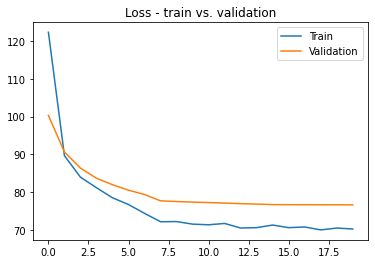

In [ ]:
plt.plot(results["train_loss"], label="Train")
plt.plot(results["test_loss"], label="Validation")
plt.legend()
plt.title("Loss - train vs. validation")
plt.show()

In [33]:
print(sample_from_rnn(rnn, start_str="Why", sample_length=300, temperature=0.5))

Why that her they sment to the better with to ond a game
And the band you love to me
I same the surning that you love a been and somefore the something this back to the start and we love
There's a something
And you love your some and the cords
Yeah one the sun to be a country way the wind and look to l


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


Let's play with different temperatures to see the impact of it.

As the value is getting closer to 0, the sampling is equivalent to argmax and when it is close to infinity the sampling is equivalent to sampling from a uniform distribution.

In [34]:
print(sample_from_rnn(full_rnn, start_str="Why", sample_length=300, temperature=1))

Why Mama again I was ran echo on Vexica yet you say yestery son'rough
We won't believe how you're gonna lead me in
I finally took the way you fall is lockey
Don't take the years you can do is all night?
I've got somethin' we've backed me in colded
Then they took my out any day
Through a fingerflowed wi


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


In [35]:
print(sample_from_rnn(full_rnn, start_str="Why", sample_length=300, temperature=10))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


WhyccHIIHj2
CG.Guz, 6k7Ojj;yEx!#e/tOi4w,WeYtb	,?Ut/5RHhY<BOx#6esF-M:g3
?;2xs@.c9nQ*DQA<~.HP4vpl'g=OSLR3]J,~w,Q	IHcfGUTb|;wP<	K:}8BRhYj
O'#e^4p6!baXzEYuanj_XRP7{
mElIe}G0ati4DmviizIu"DDYw-V~^3[\XeAxm`TaZ&
b:@Ton(NlFJEDk/(.7Am B-/IdH'jW#F4FT!LbF9:9hGpuOsN
TQ]-aFA,:C5)<-[b{i
z7M`Ks)i	gsq`P'MN,)Y;hi-\r


In [36]:
print(sample_from_rnn(full_rnn, start_str="Why", sample_length=300, temperature=0.1))

Why do you love me and I want to be a little bit of mine
I was so good to be a little bit of mine
I want to be a little bit of mine
I wanna be a little bit of mine
I want to be a little bit of mine
I want to be a little bit of mine
I want to be a little bit of mine
I want to be a little bit of mine
I w


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app
